<h1>  Project of DDML </h1>

<h3>Author :</h3>
    <ul>
    <li> 
    Thibault POUX
    </li> 
    <li> 
    Pablo García
    </li> 
    <li> 
    Nabil Kaci 
    </li> 
    </ul>

<style>
.container {
    display: flex;
    flex-wrap: wrap;
    justify-content: center;
}

.image-group {
    display: flex;
    flex-direction: row;
    align-items: center;
    margin-bottom: 20px;
}

.image-box img {
    width: 300px; /* Adjust the width as needed */
    height: 300px; /* Adjust the height as needed */
    object-fit: cover;
}

.image-box img {
    max-width: 100%;
    height: auto;
}

.summary {
    margin-top: 20px;
}



.summary li {
    margin-bottom: 10px;
}
</style>

<div class="container">
    <div class="title">
        <h2>MRI Images of brain:</h2>
    </div>
    <div class="image-group">
        <div class="image-box">
            <img src="Dataset\no\no_3.jpg" alt="Image 1">
        </div>
        <div class="image-box">
            <img src="Dataset\no\no_78.jpg" alt="Image 2">
        </div>
    </div>
</div>

<div class="container">
    <div class="title">
        <h2>MRI Images for brain with a tumor:</h2>
    </div>
    <div class="image-group">
        <div class="image-box">
            <img src="Dataset\yes\yes_2.jpg" alt="Image 3">
        </div>
        <div class="image-box">
            <img src="Dataset\yes\yes_12.jpg" alt="Image 4">
        </div>
    </div>
</div>


<div class="summary">
    <h2>Summary</h2>
    <ul>
        <li>Number of cancer images: 155</li>
        <li>Number of non-cancer images: 98</li>
        <li>Link to dataset page: <a href="https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection">Kaggle.com</a></li>
    </ul>
</div>

In [1]:

# All import libraries

import numpy as np
import matplotlib.pyplot as plt

# slkearn libraries
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix, roc_curve

# tensorflow libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

import time
from tabulate import tabulate

# Homemade package
from codigo.prep_data import data_proccesing
from codigo.prep_data import data_preProcessing
from codigo import models
from codigo import plotting

# Preporcessing the data if needed
data_preProcessing.run()

# Import the data
X_flatten, Y_flatten = data_proccesing.load_data_flatten()




In [3]:
# Variables
r_state = [914, 895, 365, 264, 59, 500, 129]
pourcentage_of_test_data = 0.33

# We define all the best models out of the knn and the mlp that are we gonna use

reg_Quadra = QuadraticDiscriminantAnalysis()   
reg_KNN = KNeighborsClassifier(n_neighbors=1)
reg_KMeans = KMeans(n_clusters=2)
reg_MLP = MLPClassifier(max_iter=10000, solver='adam', learning_rate_init=0.0001 , alpha=1e-5, hidden_layer_sizes=(14, 12))

# Dictionary to map readable names to model abbreviations
pretty_Names = {'quadra':'Quadratic Discriminant Analysis', 'knn':'K-Nearest Neighbors', 'mlp':'Multi-Layer Perceptron', 'kmeans':'KMeans'}

# Dictionary to store model results
data = {'quadra':{}, 'knn':{}, 'mlp':{}, 'kmeans':{}}

# Initialize data within the dictionary
for key in data.keys():
    data[key]['f1'] = []
    data[key]['false_negatif'] = []
    data[key]['accuracy'] = [] 
    data[key]['time_fit'] = 0
    data[key]['time_predict'] = 0

# Loop for iterating over different random seeds
for int_state in r_state:


    # Splitting the data into train and test sets
    # Make the sample with houldout
    X_train, X_test, Y_train, Y_test = train_test_split(X_flatten, Y_flatten, test_size=pourcentage_of_test_data, random_state=int_state)

    
    #Loop for iterating over the models
    for reg, name in zip([reg_Quadra, reg_KNN, reg_MLP, reg_KMeans], data.keys()): 
        start_time = time.time()          # Start time for fitting
        reg = reg.fit(X_train, Y_train)   # Fitting the model
        end_fit = time.time()             # End time for fitting
        result = reg.predict(X_test)      # Predictions
        end_predict = time.time()         # End time for prediction
        
        # Calculating metrics and times
        data[name]['f1'].append(f1_score(Y_test, result, average='weighted'))                                  # F1 score
        data[name]['false_negatif'].append(confusion_matrix(Y_test, result).ravel()[2])    # False negatives
        data[name]['accuracy'].append(balanced_accuracy_score(Y_test, result))             # Balanced accuracy score
        data[name]['time_fit'] += end_fit - start_time                                     # Accumulated fitting time
        data[name]['time_predict'] += end_predict - end_fit                                # Accumulated prediction time

# Part to display the results

# Print the results in a table
output_data = []
for key in data.keys():
    name = pretty_Names.get(key)                                                        # Readable name of the model
    f1 = np.mean(data[key]['f1']).round(2)                                              # Average F1 score
    balanced_acc = np.mean(data[key]['accuracy']).round(2)                      # Average balanced accuracy
    f_neg = str((np.mean(data[key]['false_negatif'])/len(Y_test)*100).round(2)) + '%'   # Average false negatives
    time_fit = (data[key]['time_fit']/len(r_state))                                     # Average fitting time
    time_predict = (data[key]['time_predict']/len(r_state))                             # Average prediction time
    output_data.append([name, f1, balanced_acc, f_neg, time_fit, time_predict])
    
# Print the results in a tabular format
print(f"Average of the different models, for {len(r_state)} different test, with {pourcentage_of_test_data*100}% of the data used the test set.")
print(tabulate(output_data, headers=['Model', 'F1 Score','Accuracy', 'False negative', 'Time to fit', 'Time to predict'], tablefmt='grid'))


# Plot a graph of the score for each model and for each iterration with a other curve for the average
plt.plot(data['quadra']['f1'], label='Quadratic', color='red')  # F1 scores for Quadratic Discriminant Analysis model
plt.plot(data['knn']['f1'], label='KNN', color='blue')          # F1 scores for K-Nearest Neighbors model
plt.plot(data['mlp']['f1'], label='MLP', color='green')         # F1 scores for Multi-Layer Perceptron model
plt.plot(data['kmeans']['f1'], label='KMeans', color='yellow')         # F1 scores for Multi-Layer Perceptron model

# Dashed lines to represent the average F1 for each model
plt.plot([sum(data['quadra']['f1'])/len(data['quadra']['f1'])]*len(data['quadra']['f1']), label='Quadratic average',   color='red', linestyle='--')
plt.plot([sum(data['knn']['f1'])/len(data['knn']['f1'])]*len(data['knn']['f1']), label='KNN average', color='blue', linestyle='--')
plt.plot([sum(data['mlp']['f1'])/len(data['mlp']['f1'])]*len(data['mlp']['f1']), label='MLP average', color='green', linestyle='--')
plt.plot([sum(data['kmeans']['f1'])/len(data['kmeans']['f1'])]*len(data['kmeans']['f1']), label='KMeans average', color='yellow', linestyle='--')
plt.xlabel('Number of iteration') # Label for the x-axis
plt.ylabel('F1 score')            # Label for the y-axis
plt.title('F1 score for each model (test repetead 6 times)') # Title of the plot
plt.legend()        # Add legend to the plot
plt.show()          # Show the plot


C:\Users\thiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\thiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\thiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\thiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn

Average of the different models, for 7 different test, with 33.0% of the data used the test set.
+---------------------------------+------------+------------+------------------+---------------+-------------------+
| Model                           |   F1 Score |   Accuracy | False negative   |   Time to fit |   Time to predict |
+=================================+============+============+==================+===============+===================+
| Quadratic Discriminant Analysis |       0.55 |       0.61 | 34.69%           |   0.544024    |         0.0391852 |
+---------------------------------+------------+------------+------------------+---------------+-------------------+
| K-Nearest Neighbors             |       0.65 |       0.68 | 28.74%           |   0.000734295 |         0.043933  |
+---------------------------------+------------+------------+------------------+---------------+-------------------+
| Multi-Layer Perceptron          |       0.63 |       0.62 | 13.44%           |   4

<h2>Test for several neighbors in KNN, from 1 to 25.</h2>

In [5]:
# getting all the data for the KNN model
array_numnber_of_neighboor = [i for i in range(1, 26, 1)]
data = models.KNN_range((X_flatten, Y_flatten), array_numnber_of_neighboor, size_sample=0.2)


In [6]:
# ploting the results to annlaysis the best number of neighbors for the KNN model

fig, ax1 = plt.subplots()

# Plot F1 score on the first subplot
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('F1 score', color='tab:blue')
ax1.plot(array_numnber_of_neighboor, data['f1'], color='tab:blue', label='F1 score')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()  
ax2.set_ylabel('False negative %', color='tab:red')
ax2.plot(array_numnber_of_neighboor, data['fn'], color='tab:red', label='False negative')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('F1 score and False Negative for KNN with 1 to 25 neighbors')
fig.tight_layout() 
plt.show()                                                         # Show the plot

<h3>KNN Model Evaluation</h3>
<p>I can see that the number of neighbors that gives the best result is about 20 (it depends on the seeds, but we can say 21). This value is the best because it maximizes the F1 score while also minimizing the false negative rate. </p>
<p>We are choosing 21 over 25 even though the results are similar because with fewer neighbors the algorithm is more efficient.</p>

<p>Best value of K: 21</p>

<h2>K-means</h2>

In [50]:
numero_de_paso = 5
data = models.K_means((X_flatten, Y_flatten) , numero_de_paso)

In [51]:
# Print data :
# Plotting the results to annlaysis the best number of neighbors for the KNN model
# Create a figure and subplots


# Create a figure and subplots
fig, ax1 = plt.subplots()

# Array of the number of iterations
nbr_of_clusters = [i for i in range(1, numero_de_paso + 1, 1)]

# Plot F1 score on the first subplot
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('F1 score', color='tab:blue')
ax1.plot(nbr_of_clusters, data['f1'], color='tab:blue', label='F1 score')
ax1.plot(nbr_of_clusters, [np.mean(data['f1'])] * len(nbr_of_clusters), color='tab:blue', linestyle='--', label='F1 score average')
ax1.tick_params(axis='y', labelcolor='tab:blue')
plt.legend(loc='upper left')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('False negative %', color='tab:red')
ax2.plot(nbr_of_clusters, data['fn'], color='tab:red', label='False negative')
ax2.plot(nbr_of_clusters, [np.mean(data['fn'])] * len(nbr_of_clusters), color='tab:red', linestyle='--', label='False negative average')
ax2.tick_params(axis='y', labelcolor='tab:red')
plt.legend(loc='upper right')

plt.title('F1 score and False negative for K-Means 1 to 5 iterations')
fig.tight_layout()
plt.show() 

<h2>MLP</h2>

In [14]:
# Let's assume X_flatten and Y_flatten are your data
# X_flatten is a feature matrix and Y_flatten are the labels
r_state = [914, 895, 365, 264, 59, 500, 129]

# Define lists to store the results
neurons_range = range(1, 16)                                            # Range of neurons for hidden layers
accuracies = np.zeros((len(neurons_range), len(neurons_range)))         # Array to store accuracies
f1_scores = np.zeros((len(neurons_range), len(neurons_range)))          # Array to store F1 scores
falseNegatives = np.zeros((len(neurons_range), len(neurons_range)))     # Array to store false negatives

# Train several MLPs with different configurations
for i, neurons1 in enumerate(neurons_range):
    for j, neurons2 in enumerate(neurons_range):
        for r in r_state:        
            # First, we split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X_flatten, Y_flatten, test_size=0.2, random_state=r)
            # Create MLP with current configuration
            mlp = MLPClassifier(max_iter=10000, hidden_layer_sizes=(neurons1,neurons2) , learning_rate_init=0.0001, solver='adam', alpha=1e-5,random_state=r)
            
            # Fit MLP to training data
            mlp.fit(X_train, y_train)
            
            # Predict on test data
            y_pred = mlp.predict(X_test)
            
            # Calculate accuracy, F1 score, and false negatives
            acc = balanced_accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            
            accuracies[i, j] += acc
            f1_scores[i, j] += f1
            falseNegatives[i,j] += confusion_matrix(y_test, y_pred).ravel()[2]
        accuracies[i, j] = accuracies[i, j]/len(r_state)
        f1_scores[i, j] = f1_scores[i, j] /len(r_state)
        falseNegatives[i,j] = falseNegatives[i,j]/len(r_state)
        


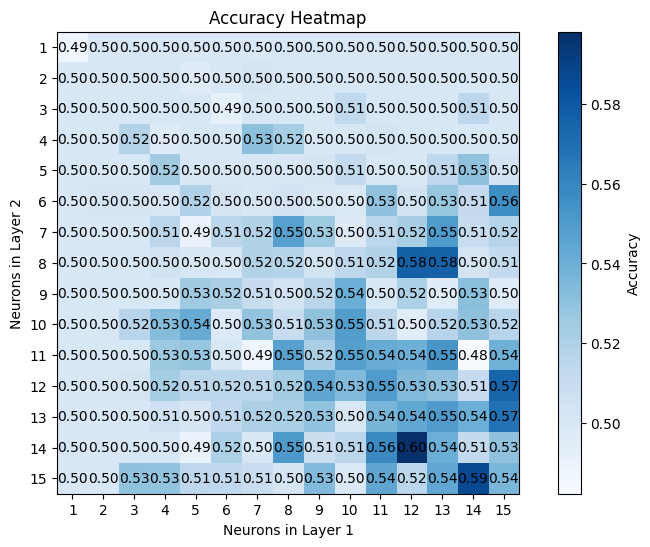

In [15]:
# Plotting accuracy heatmap with annotations
plt.figure(figsize=(10, 6))                                         # Create a figure with a specific size
plt.imshow(accuracies, interpolation='nearest', cmap=plt.cm.Blues)  # Display accuracy heatmap
plt.title('Accuracy Heatmap')                                       # Set title for the plot
plt.xlabel('Neurons in Layer 1')                                    # Set label for x-axis
plt.ylabel('Neurons in Layer 2')                                    # Set label for y-axis
plt.colorbar(label='Accuracy')                                      # Add colorbar with label
plt.xticks(np.arange(len(neurons_range)), neurons_range)            # Set ticks and labels for x-axis
plt.yticks(np.arange(len(neurons_range)), neurons_range)            # Set ticks and labels for y-axis

for i in range(len(neurons_range)):
    for j in range(len(neurons_range)):
        
        # Annotate heatmap with accuracy value
        plt.text(j, i, f'{accuracies[i, j]:.2f}', ha='center', va='center', color='black')
plt.show()

# Plotting F1 score heatmap with annotations
plt.figure(figsize=(10, 6))                                         # Create a figure with a specific size
plt.imshow(f1_scores, interpolation='nearest', cmap=plt.cm.Reds)    # Display F1 score heatmap
plt.title('F1 Score Heatmap')                                       # Set title for the plot
plt.xlabel('Neurons in Layer 1')                                    # Set label for x-axis
plt.ylabel('Neurons in Layer 2')                                    # Set label for y-axis
plt.colorbar(label='F1 Score')                                      # Add colorbar with label
plt.xticks(np.arange(len(neurons_range)), neurons_range)            # Set ticks and labels for x-axis
plt.yticks(np.arange(len(neurons_range)), neurons_range)            # Set ticks and labels for y-axis

for i in range(len(neurons_range)):
    for j in range(len(neurons_range)):
        
        # Annotate heatmap with F1 score values
        plt.text(j, i, f'{f1_scores[i, j]:.2f}', ha='center', va='center', color='black')
plt.show()

# Plotting false negatives heatmap
plt.figure(figsize=(10, 6))                                                 # Create a figure with a specific size
plt.imshow(falseNegatives, interpolation='nearest', cmap=plt.cm.Greens)     # Display false negatives heatmap
plt.title('False Negatives Heatmap')                                        # Set title for the plot
plt.xlabel('Neurons in Layer 1')                                            # Set label for x-axis
plt.ylabel('Neurons in Layer 2')                                            # Set label for y-axis
plt.colorbar(label='False Negatives')                                       # Add colorbar with label
plt.xticks(np.arange(len(neurons_range)), neurons_range)                    # Set ticks and labels for x-axis
plt.yticks(np.arange(len(neurons_range)), neurons_range)                    # Set ticks and labels for y-axis

for i in range(len(neurons_range)):
    for j in range(len(neurons_range)):
        
        # Annotate heatmap with false negative values
        plt.text(j, i, f'{falseNegatives[i, j]:.0f}', ha='center', va='center', color='black')
plt.show()

<h2>CNN </h2>

In [52]:
# Preporcessing the data if needed
data_preProcessing.run()

# Import the data
X, Y = data_proccesing.load_data()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# Reshape the labels
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

Processing file: Dataset/yes\yes_1.jpg
Processing file: Dataset/yes\yes_10.jpg
Processing file: Dataset/yes\yes_100.jpg
Processing file: Dataset/yes\yes_101.jpg
Processing file: Dataset/yes\yes_102.jpg
Processing file: Dataset/yes\yes_103.jpg
Processing file: Dataset/yes\yes_104.jpg
Processing file: Dataset/yes\yes_105.jpg
Processing file: Dataset/yes\yes_106.jpg
Processing file: Dataset/yes\yes_107.jpg
Processing file: Dataset/yes\yes_108.jpg
Processing file: Dataset/yes\yes_109.jpg
Processing file: Dataset/yes\yes_11.jpg
Processing file: Dataset/yes\yes_110.jpg
Processing file: Dataset/yes\yes_111.jpg
Processing file: Dataset/yes\yes_112.jpg
Processing file: Dataset/yes\yes_113.jpg
Processing file: Dataset/yes\yes_114.jpg
Processing file: Dataset/yes\yes_115.jpg
Processing file: Dataset/yes\yes_116.jpg
Processing file: Dataset/yes\yes_117.jpg
Processing file: Dataset/yes\yes_118.jpg
Processing file: Dataset/yes\yes_119.jpg
Processing file: Dataset/yes\yes_12.jpg
Processing file: Data

In [53]:
# Create the model
# Initialize a Sequential model
model = Sequential()

# Add Convolutional and Pooling layers
model.add(Conv2D(32,(3,3),activation= 'relu', input_shape =(128, 128, 1) ))   # Add Conv2D layer with 32 filters, relu activation function, and input shape
model.add(MaxPooling2D((2,2)))                                                # Add MaxPooling2D layer with pool size (2,2)
model.add(Conv2D(32,(3,3),activation= 'relu'))                                # Add another Conv2D layer with 32 filters and relu activation function
model.add(MaxPooling2D((2,2)))                                                # Add another MaxPooling2D layer with pool size (2,2)

# Flatten the output from Convolutional layers
model.add(Flatten())                            # Flatten the output from Convolutional and Pooling layers                                           

# Add Dense layers
model.add(Dense(65, activation='relu'))         # Add Dense layer with 65 neurons and relu activation function

model.add(Dense(1, activation= 'sigmoid'))      # Add Dense layer with 1 neuron and sigmoid activation function


# Print model summary
model.summary()                                 # Print a summary of the model architecture


C:\Users\thiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 65)             │     1,872,065 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,881,699 (7.18 MB)

 Trainable params: 1,881,699 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Assuming y_pred and y_true are numpy arrays
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (202, 128, 128, 1)
Shape of X_test: (51, 128, 128, 1)
Shape of y_train: (202, 1)
Shape of y_test: (51, 1)


In [55]:

# Define F1 score metric
f1 = F1Score(average=None, threshold=None, name="f1_score", dtype=None)  
model.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy',f1])   # Compile the model with binary crossentropy loss, Adam optimizer, and accuracy and F1 score metrics 
model.fit(X_train,y_train, epochs= 10, batch_size=64 ,class_weight={0: 155/253, 1: 98/253})                                   # Train the model on X_train and y_train data for 10 epochs with a batch size of 64

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.4999 - f1_score: 0.6732 - loss: 30.1679 
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5284 - f1_score: 0.7846 - loss: 4.7435 
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6885 - f1_score: 0.7667 - loss: 0.7210 
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6677 - f1_score: 0.7599 - loss: 0.5471 
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8343 - f1_score: 0.7476 - loss: 0.1899
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8565 - f1_score: 0.7768 - loss: 0.1262
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9374 - f1_score: 0.7428 - loss: 0.0791 
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9755 - f1_score: 0.7507 - loss: 0.0522 
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9631 - f1_score: 0.7581 - loss: 0.0391 
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - f

In [56]:
model.evaluate(X_test, y_test)      # Evaluate the trained model on X_test and y_test data

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8303 - f1_score: 0.7782 - loss: 1.0243 


[1.050042748451233, 0.8235294222831726, 0.7710843086242676]

In [57]:
# Define a list of dense activation sizes to iterate over
dense_activation_sizes = [32, 64, 128, 256]

# Iterate over different dense activation sizes
for dense_activation_size in dense_activation_sizes:
    # Create and train the model
    model, history = models.cnn(dense_activation_size, X_train, y_train)
    
    # Evaluate the model on test data
    loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred>0.5)
    weighted_f1 = f1_score(y_test, y_pred>0.5, average='weighted')
    FN = confusion_matrix(y_test, y_pred>0.5).ravel()[2]
    # Print the results
    print(f"Dense Activation Size: {dense_activation_size}")
    print(f"Test Accuracy: {accuracy}")
    print(f"Test F1 Score: {f1}")
    print(f"Test F1 weight Score: {weighted_f1}")
    print(f"Test False Negatives: {FN}")
    print(f"Test Precision: {precision}")
    print(f"Test Recall: {recall}")
    print("------------------------------------------------------")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8041 - loss: 0.4724 - precision: 0.8104 - recall: 0.9058 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Dense Activation Size: 32
Test Accuracy: 0.7843137383460999
Test F1 Score: 0.8405797101449275
Test F1 weight Score: 0.7757885763000851
Test False Negatives: 3
Test Precision: 0.7837837934494019
Test Recall: 0.90625
------------------------------------------------------


C:\Users\thiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7571 - loss: 1.3657 - precision_1: 0.7772 - recall_1: 0.8690  
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000013990274CC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Dense Activation Size: 64
Test Accuracy: 0.7450980544090271
Test F1 Score: 0.8115942

C:\Users\thiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7310 - loss: 0.6695 - precision_2: 0.7592 - recall_2: 0.8482 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Dense Activation Size: 128
Test Accuracy: 0.7058823704719543
Test F1 Score: 0.782608695652174
Test F1 weight Score: 0.6942571495001163
Test False Negatives: 5
Test Precision: 0.7297297120094299
Test Recall: 0.84375
------------------------------------------------------


C:\Users\thiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8068 - loss: 1.1205 - precision_3: 0.8347 - recall_3: 0.8690 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Dense Activation Size: 256
Test Accuracy: 0.8039215803146362
Test F1 Score: 0.8484848484848485
Test F1 weight Score: 0.8014458308575955
Test False Negatives: 4
Test Precision: 0.8235294222831726
Test Recall: 0.875
------------------------------------------------------


<h1>Model Evaluation</h1>

In [2]:
# Specifing all the model to plot

full_data = {
    'quadra':{
        'name':'Quadratic Discriminant Analysis',
        'short_name':'Quadra',
        'color' : 'red',
        'model':QuadraticDiscriminantAnalysis()},
    'knn':{
        'name':'K-Nearest Neighbors',
        'short_name':'KNN',
        'color' : 'blue',
        'model':KNeighborsClassifier(n_neighbors=1)},
    'mlp':{
        'name':'Multi-Layer Perceptron',
        'short_name':'MLP',
        'color' : 'green',
        'model':MLPClassifier(max_iter=10000, solver='adam', learning_rate_init=0.0001 , alpha=1e-5, hidden_layer_sizes=(14, 12))},
    'kmeans':{  
        'name':'KMeans',
        'short_name':'KMeans',
        'color' : 'yellow',
        'model':KMeans(n_clusters=2)}
    }


<h3>Diagram</h3>

In [59]:
full_data_copy = full_data.copy()
# get the data for holdout 
output_holdout = models.getData_allModels_Holdout(X_flatten, Y_flatten, full_data_copy)

output_holdout['cnn'] ={
    'name':'Convolutional Neural Network',
    'short_name':'CNN',
    'color' : 'pink',
    'f1' : 0.84,
    'false_negatif' : 3,
    'f1_weighted' : 0.77}


plotting.printHistogram('F1 Score and False Negatives by Model, with holdout' , output_holdout)

C:\Users\thiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\thiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\thiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\thiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn

C:\Users\thiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\thiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\thiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\thiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn

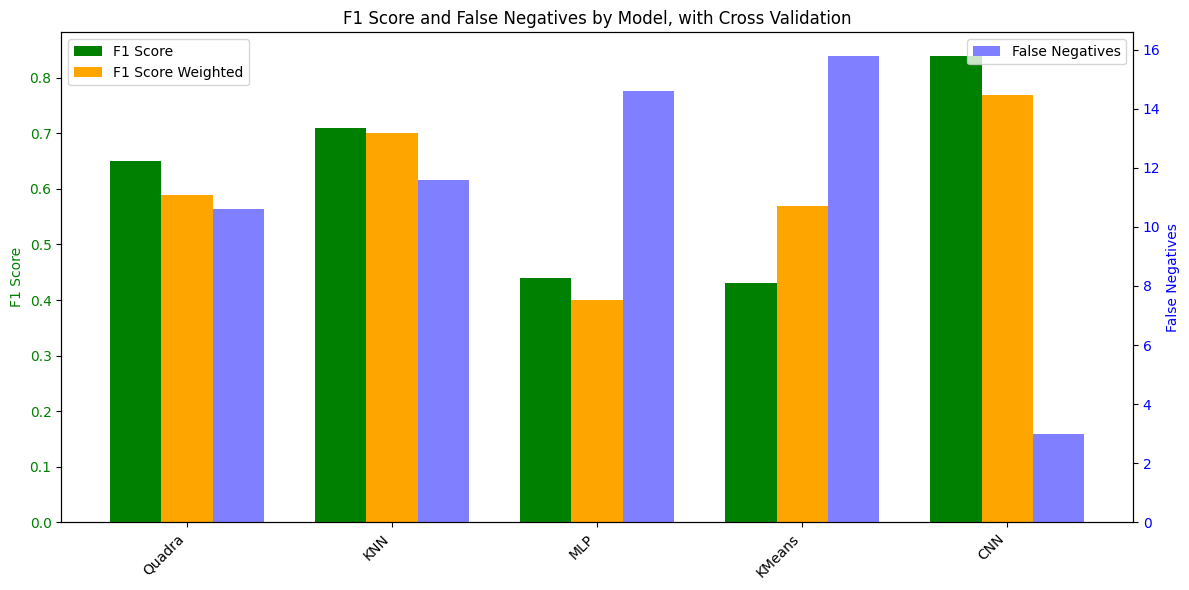

In [4]:
# importante !
# sometimes the function that calculated the cross validation can take have issues to run, if it's the case, please run the function again

full_data_copy = full_data.copy()
# get the data for holdout 
output = models.getData_allModels_CrossValidation(X_flatten, Y_flatten, full_data_copy)

output['cnn'] ={
    'name':'Convolutional Neural Network',
    'short_name':'CNN',
    'color' : 'pink',
    'f1' : 0.84,
    'false_negatif' : 3,
    'f1_weighted' : 0.77}


plotting.printHistogram('F1 Score and False Negatives by Model, with Cross Validation' , output)

<h3>Roc Curve</h3>

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9903 - loss: 0.0344 - precision_3: 1.0000 - recall_3: 0.9842 
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9873 - loss: 0.0282 - precision_3: 0.9950 - recall_3: 0.9840
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9924 - loss: 0.0173 - precision_3: 0.9925 - recall_3: 0.9951
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9923 - loss: 0.0150 - precision_3: 0.9873 - recall_3: 1.0000
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 0.0109 - precision_3: 1.0000 - recall_3: 1.0000
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 0.0094 - precision_3: 1.0000 - recall_3: 1.0000
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 1.0000 - loss: 0.0051 - precision_3: 1.0000 - recall_3: 1.0000
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 1.0000 - loss: 0.0053 - precision_3: 1.0000 - recall_3: 1.0000


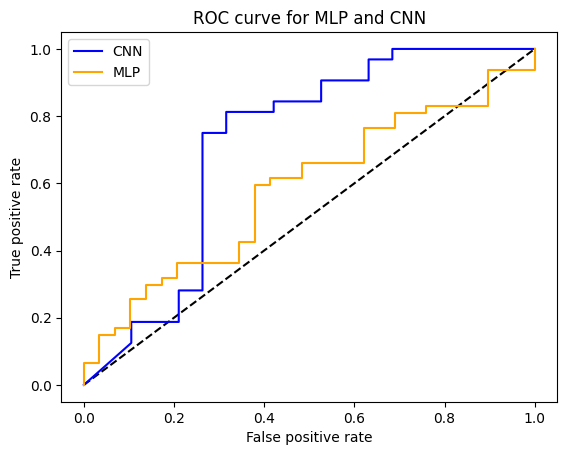

In [61]:
# printing the roc curve for CNN and MLP

# to have the data to print the roc curve

# for the CNN model
model.fit(X_train, y_train, epochs=10, batch_size=64, class_weight={0: 155/253, 1: 98/253})  # Train the model on X_train and y_train data for 10 epochs with a batch size of 64
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, _ = roc_curve(y_test, y_pred_keras)
name_keras = 'CNN'

# for the MLP model
fpr_mlp = output_holdout['mlp']['fpr'][0]
tpr_mlp = output_holdout['mlp']['tpr'][0]
name_mlp = 'MLP'

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')  #plot x=y line
plt.plot(fpr_keras, tpr_keras, label=name_keras, color="blue") #plot the ROC curve for the CNN model
plt.plot(fpr_mlp, tpr_mlp, label=name_mlp, color="orange") #plot the ROC curve for the MLP model
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for MLP and CNN')
plt.legend(loc='upper left')
plt.show()